In [2]:
library(tidyverse)
library(universalmotif)
#library(MotifDb)
library(cowplot)

# # Assuming 'your_output.meme' is the output MEME file from xstreme
# motifs_from_xstreme <- read_meme('/scratch/jpm73279/comparative_single_cell/07.call.ACRs/06.motif_enrichment/zm_dir/mesophyll/xstreme/combined.meme')

# # If you only want a subset of the motifs, you can subset them. 
# # Here we'll use all of them for demonstration:
#motifs <- convert_motifs(motifs_from_xstreme)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2          ✔ readr     2.1.4     
✔ forcats   1.0.0.9000     ✔ stringr   1.5.1     
✔ ggplot2   3.4.4          ✔ tibble    3.2.1     
✔ lubridate 1.9.2          ✔ tidyr     1.3.0     
✔ purrr     1.0.2          
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp




In [3]:
zm_meso_test <- read_tsv("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/06.motif_enrichment/zm_dir/mesophyll/xstreme/xstreme.tsv")
head(zm_meso_test)

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 30 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (7): RANK, SOURCE, ID, ALT_ID, CONSENSUS, SIM_SOURCE, SIM_MOTIF
dbl (7): SEED_MOTIF, CLUSTER, WIDTH, SITES, SEA_PVALUE, EVALUE, EVALUE_ACC
lgl (1): MOTIF_URL

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


RANK SEED_MOTIF CLUSTER SOURCE ID              ALT_ID   CONSENSUS       WIDTH
1 NA   1          1       MEME   AWAWAWAAAWAAAWA MEME-1   AWAWAWAAAWAAAWA 15   
2 NA   1          2       MEME   GRCGRCGRCGRCGVS MEME-2   GRCGRCGRCGRCGVS 15   
3 NA   1          3       STREME 1-CAYGYACGY     STREME-1 CAYGYACGY        9   
4 NA   0          1       STREME 2-AAAAAAAMR     STREME-2 AAAAAAAMR        9   
5 NA   1          4       STREME 3-CCACACGCC     STREME-3 CCACACGCC        9   
6 NA   1          5       STREME 4-ACGTGACG      STREME-4 ACGTGACG         8   
  SITES SEA_PVALUE EVALUE   EVALUE_ACC
1 1196  2.72       7.50e-59 1         
2  596  2.72       7.30e-29 1         
3 1785  2.72       6.78e-21 1         
4 1125  2.72       6.01e-11 1         
5 1578  2.72       1.27e-08 1         
6 1106  2.72       8.20e-08 1         
  SIM_SOURCE                                    SIM_MOTIF  MOTIF_URL
1 00.data/conserved_consensus_motifs_Fig2B.meme MADS_MIKC  NA       
2 00.data/conserved_consensus_motifs_Fig2B.meme AS2LOB     NA       
3 00.data/conserved_consensus_motifs_Fig2B.meme NAC        NA       
4 00.data/conserved_consensus_motifs_Fig2B.meme C2C2_Dof   NA       
5 00.data/conserved_consensus_motifs_Fig2B.meme CAMTA      NA       
6 STREME                                        4-ACGTGACG NA

In [4]:
zm_meso_test$SIM_MOTIF

[1] "MADS_MIKC"         "AS2LOB"            "NAC"              
 [4] "C2C2_Dof"          "CAMTA"             "4-ACGTGACG"       
 [7] "5-GCAGCA"          "6-TATATATAT"       "AS2LOB"           
[10] "8-AAMCAAACAAAM"    "BES1"              "NAC"              
[13] "bHLH_TCP"          "12-CACACACACACA"   "13-CRTCCRTCC"     
[16] "ARF"               "15-GACAGGASA"      "BBRBPC"           
[19] "ARF"               "SBP"               "BES1"             
[22] "20-CCCKGCCCYGS"    "21-CTAGCTA"        "22-TAAAATAT"      
[25] "23-TCCAGTCCAGTCCA" "GARP_ARR-B"        "25-VYGCSGCRB"     
[28] NA                  NA                  NA

In [5]:
# quantile(zm_meso_test$EVALUE, na.rm = TRUE)

In [6]:
filter_motifs <- function(tsv_file, meme_file, species, cell_type) {
  
  # Step 1: Filter TSV file
  tsv_data <- read_tsv(tsv_file, show_col_types = FALSE) %>%
    #filter(SIM_SOURCE == "00.data/conserved_consensus_motifs_Fig2B.meme") %>% 
    #filter(SOURCE == "MEME") %>% 
    mutate(streme_alt_id = str_c(ID,ALT_ID, sep = "-"))# %>% 
    #dplyr::filter(EVALUE < .03)
  
  # Step 2: Read MEME file
  motifs_list <- read_meme(meme_file)
  
  filtered_motifs_list <- lapply(motifs_list, function(motif) {
    if(motif@altname %in% tsv_data$streme_alt_id) {
      motif_family <- filter(tsv_data, streme_alt_id == motif@altname)$SIM_MOTIF
      motif@family <- as.character(motif_family)
      motif@organism <- species
      
      # Add the "species" and "cell_type" to the altname field
      motif@altname <- paste(motif@altname, species, cell_type, sep = "_")

      
      return(motif)
    } else {
      return(NULL)
    }
  })
  
  # Filter out motifs with a homopolymer (e.g., "AAAAA")
  # Extract the consensus sequences from each motif
  consensus_sequences <- sapply(filtered_motifs_list, function(x) if (!is.null(x)) x@consensus else NULL)

  # Search for motifs that have the pattern of five identical nucleotides
  has_homopolymer <- grepl("(A{6,}|T{5,}|C{5,}|G{8,}|TATATA)", consensus_sequences)

  # Exclude the motifs with the homopolymer pattern
  filtered_motifs_list <- filtered_motifs_list[!has_homopolymer]
  
  tsv_data <- tsv_data %>% 
      mutate(ID = paste(ID, species, cell_type, sep = "_"))
    
  return(list(tsv_data = tsv_data, motifs = filtered_motifs_list))
}

                                
update_motif_altname <- function(motif_list) {
    # Iterate over the list of motifs using their names
    for (motif_name in names(motif_list)) {
        # Append the list index (motif_name) to the @altname slot of each motif
        motif_list[[motif_name]]@altname <- paste(motif_list[[motif_name]]@altname, motif_name, sep = "_")
    }
    return(motif_list)
}

## Example usage on single file
# result <- filter_motifs("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/06.motif_enrichment/zm_dir/mesophyll/xstreme/xstreme.tsv", 
# "/scratch/jpm73279/comparative_single_cell/07.call.ACRs/06.motif_enrichment/zm_dir/mesophyll/xstreme/combined.meme", 
#                         "Zm", "mesophyll")
# filtered_tsv <- result$tsv_data
# filtered_motifs <- result$motifs

In [7]:
base_path <- "/scratch/jpm73279/comparative_single_cell/07.call.ACRs/09.updated_ms_bs_acr_calling/"

file_list <- list(
  Os = list(
    meme = paste0(base_path, "os.extended_c4_genes.acrs.mesophyll/xstreme/combined.meme"),
    tsv = paste0(base_path, "os.extended_c4_genes.acrs.mesophyll/xstreme/xstreme.tsv")
  ),
  Zm = list(
    meme = paste0(base_path, "zm.extended_c4_genes.acrs.mesophyll/xstreme/combined.meme"),
    tsv = paste0(base_path, "zm.extended_c4_genes.acrs.mesophyll/xstreme/xstreme.tsv")
  ),
  Uf = list(
    meme = paste0(base_path, "uf.extended_c4_genes.acrs.mesophyll/xstreme/combined.meme"),
    tsv = paste0(base_path, "uf.extended_c4_genes.acrs.mesophyll/xstreme/xstreme.tsv")
  ),
  Pm = list(
    meme = paste0(base_path, "pm.extended_c4_genes.acrs.mesophyll/xstreme/combined.meme"),
    tsv = paste0(base_path, "pm.extended_c4_genes.acrs.mesophyll/xstreme/xstreme.tsv")
  ),
  Sb = list(
    meme = paste0(base_path, "sb.extended_c4_genes.acrs.mesophyll/xstreme/combined.meme"),
    tsv = paste0(base_path, "sb.extended_c4_genes.acrs.mesophyll/xstreme/xstreme.tsv")
  )
)

# Now, let's apply the filter_motifs function to each species' set of files:

all_filtered_motifs <- list()

for(species in names(file_list)) {
  result <- filter_motifs(file_list[[species]]$tsv, file_list[[species]]$meme, species, "mesophyll")
  all_filtered_motifs[[species]] <- result$motifs
}

# Remove NULL entries from the list of lists
all_filtered_motifs <- lapply(all_filtered_motifs, function(species_motifs) {
  Filter(Negate(is.null), species_motifs)
})

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”


In [8]:
process_motif_sublist <- function(sublist) {
    # Apply merge_similar to the sublist of motifs
    merged_motifs <- merge_similar(sublist, threshold = 0.75, normalise.scores = TRUE, min.position.ic = .5)
    return(merged_motifs)
}

# Apply the function to each sublist in your main list
all_filtered_motifs <- lapply(all_filtered_motifs, process_motif_sublist)

merged_list <- unlist(all_filtered_motifs, recursive = FALSE)
merged_list <- update_motif_altname(merged_list)


In [9]:
filtered_motifs <- lapply(merged_list, function(motif) {
  motif <- trim_motifs(motif)
  motif <- round_motif(motif)
  motif@name <- motif@altname
  return(motif)
})


In [10]:
# Generate the motif tree
tree <- motif_tree(filtered_motifs, layout = "rectangular", linecol = "organism",
                  method = "HELL")


Registered S3 method overwritten by 'ggtree':
  method      from 
  identify.gg ggfun



In [11]:
# Extract the order based on the tree
new.order <- tree$data$label[tree$data$isTip]
new.order <- rev(new.order[order(tree$data$y[tree$data$isTip])])


In [12]:
# Extract names or altname from filtered_motifs
motif_names <- sapply(filtered_motifs, function(x) x@name)

# Match the names with the new_order
order_index <- match(new.order, motif_names)

# Reorder filtered_motifs based on the matched index
reordered_motifs <- filtered_motifs[order_index]


In [13]:
#filtered_motifs <- filtered_motifs[new.order]

In [14]:
options(repr.plot.width=30, repr.plot.height=70)

# Plot the motifs and the tree side by side
ms_specific_tree <- plot_grid(nrow = 1, rel_widths = c(1, -0.15, 1),
          tree + xlab(""), NULL,
          view_motifs(reordered_motifs) +
            ylab(element_blank()) +
            theme(
              axis.line.y = element_blank(),
              axis.ticks.y = element_blank(),
              axis.text.y = element_blank(),
              axis.text = element_text(colour = "white")
            )
)

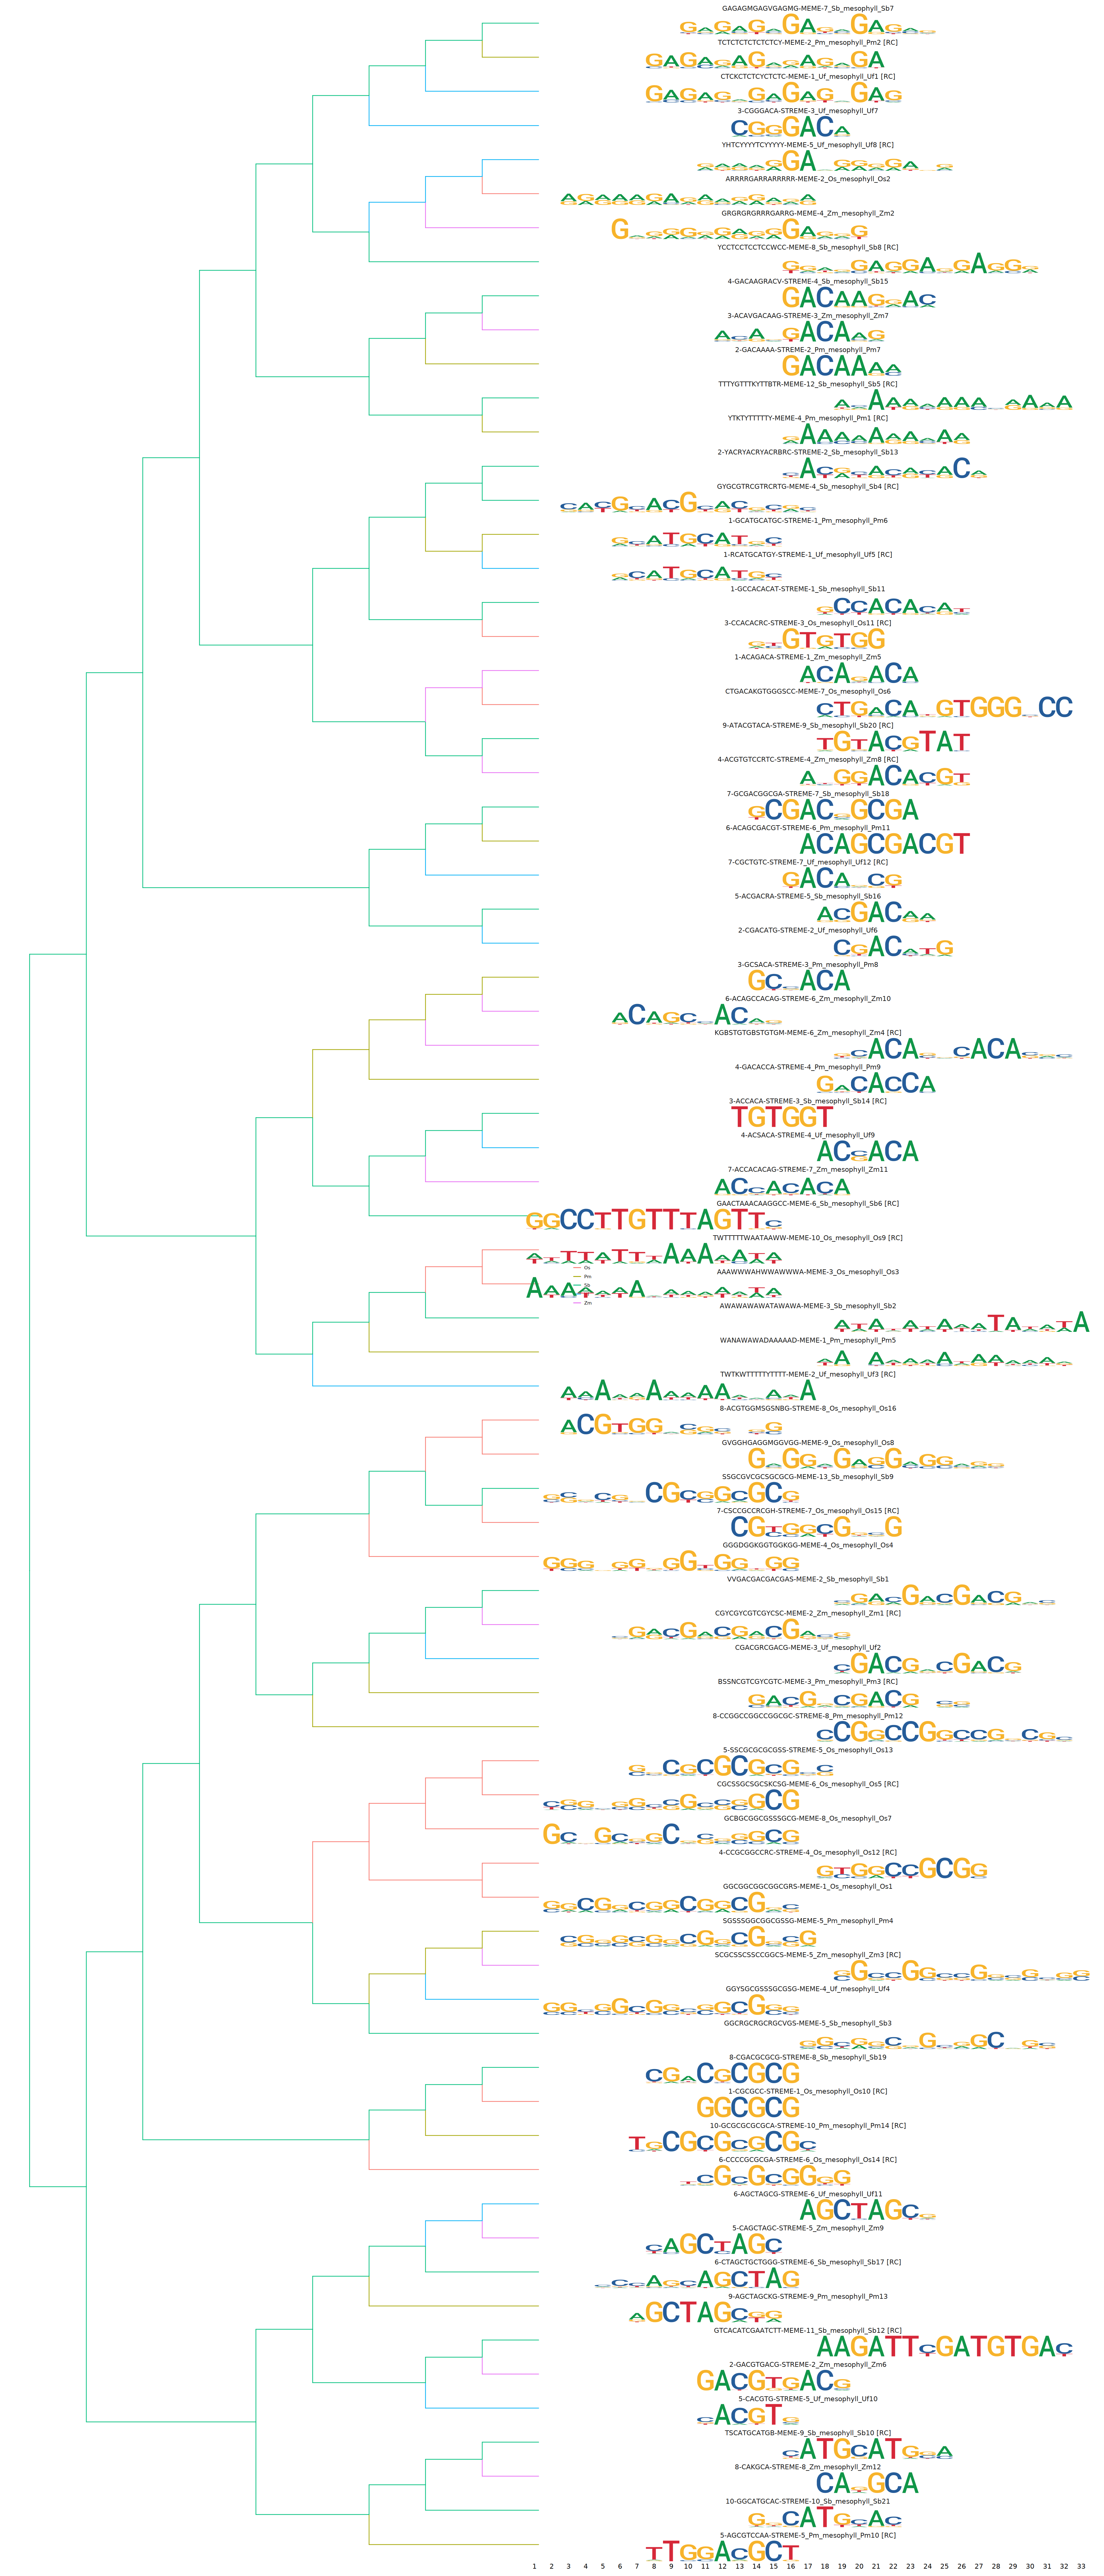

In [15]:
ms_specific_tree

In [16]:
base_path <- "/scratch/jpm73279/comparative_single_cell/07.call.ACRs/09.updated_ms_bs_acr_calling/"

file_list <- list(
  Os = list(
    meme = paste0(base_path, "os.extended_c4_genes.acrs.bundle_sheath/xstreme/combined.meme"),
    tsv = paste0(base_path, "os.extended_c4_genes.acrs.bundle_sheath/xstreme/xstreme.tsv")
  ),
  Zm = list(
    meme = paste0(base_path, "zm.extended_c4_genes.acrs.bundle_sheath/xstreme/combined.meme"),
    tsv = paste0(base_path, "zm.extended_c4_genes.acrs.bundle_sheath/xstreme/xstreme.tsv")
  ),
  Uf = list(
    meme = paste0(base_path, "uf.extended_c4_genes.acrs.bundle_sheath/xstreme/combined.meme"),
    tsv = paste0(base_path, "uf.extended_c4_genes.acrs.bundle_sheath/xstreme/xstreme.tsv")
  ),
  Pm = list(
    meme = paste0(base_path, "pm.extended_c4_genes.acrs.bundle_sheath/xstreme/combined.meme"),
    tsv = paste0(base_path, "pm.extended_c4_genes.acrs.bundle_sheath/xstreme/xstreme.tsv")
  ),
  Sb = list(
    meme = paste0(base_path, "sb.extended_c4_genes.acrs.bundle_sheath/xstreme/combined.meme"),
    tsv = paste0(base_path, "sb.extended_c4_genes.acrs.bundle_sheath/xstreme/xstreme.tsv")
  )
)

# Now, let's apply the filter_motifs function to each species' set of files:

bs_all_filtered_motifs <- list()

for(species in names(file_list)) {
  result <- filter_motifs(file_list[[species]]$tsv, file_list[[species]]$meme, species, "bundle_sheath")
  bs_all_filtered_motifs[[species]] <- result$motifs
}

# Remove NULL entries from the list of lists
bs_all_filtered_motifs <- lapply(bs_all_filtered_motifs, function(species_motifs) {
  Filter(Negate(is.null), species_motifs)
})

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”


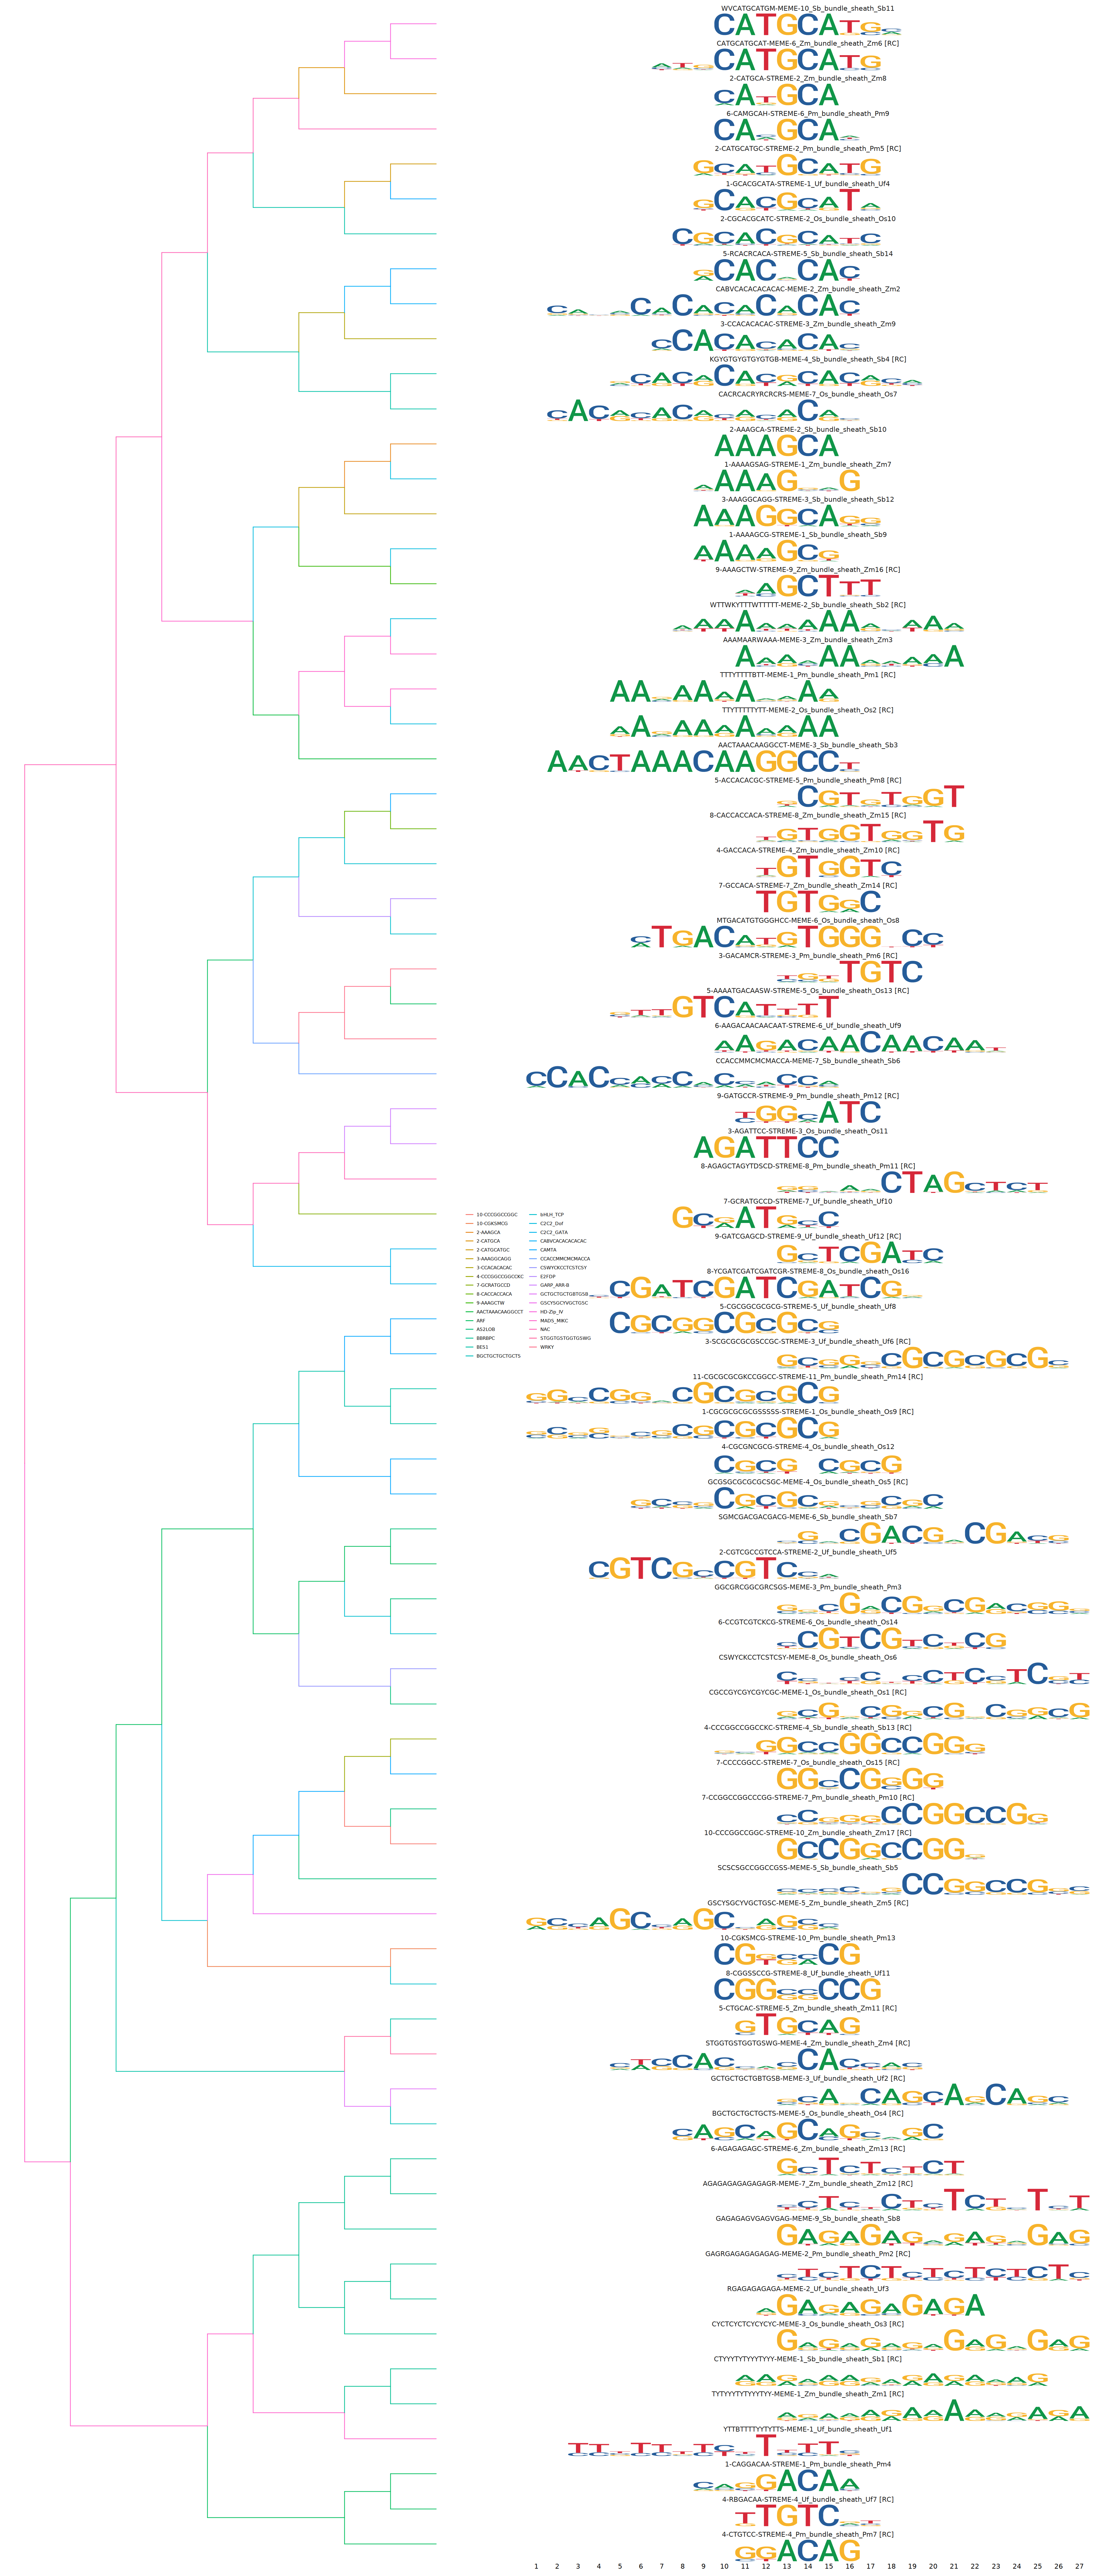

In [17]:
bs_all_filtered_motifs <- lapply(bs_all_filtered_motifs, process_motif_sublist)
bs_merged_list <- unlist(bs_all_filtered_motifs, recursive = FALSE)
bs_merged_list <- update_motif_altname(bs_merged_list)



bs_filtered_motifs <- lapply(bs_merged_list, function(motif) {
  motif <- trim_motifs(motif)
  motif <- round_motif(motif)
  motif@name <- motif@altname
  return(motif)
})


umap_cluster_colors <- c("#DEA940","#A2A763","#D6EEBE","#5894D4","#6AAD51","#6C8686","#FFD92F", "#7f2201","#b53310",
                         "#E7673B","#FB9A99","#E31A1C","#FDBF6F","#CAB2D6","#386CB0","#FFFFB3", "#5dead5","#c11577",
                         "#CCCCCC", "#7570B3","#B15928", "#6A3D9A", "#d87c6a", "#0060e8", "#84c5ff", "#ffd460", "#d81397")


# Generate the motif tree
tree_bs <- motif_tree(bs_filtered_motifs, method = "HELL",  tryRC = TRUE,
                      layout = "rectangular", linecol = "family")

# Extract the order based on the tree
bs_new.order <- tree_bs$data$label[tree_bs$data$isTip]
bs_new.order <- rev(bs_new.order[order(tree_bs$data$y[tree_bs$data$isTip])])


# Extract names or altname from filtered_motifs
bs_motif_names <- sapply(bs_filtered_motifs, function(x) x@name)

# Match the names with the new_order
bs_order_index <- match(bs_new.order, bs_motif_names)

# Reorder filtered_motifs based on the matched index
bs_reordered_motifs <- bs_filtered_motifs[bs_order_index]


#filtered_motifs <- filtered_motifs[new.order]

options(repr.plot.width=30, repr.plot.height=70)
# Plot the motifs and the tree side by side
bs_specific_tree <- plot_grid(nrow = 1, rel_widths = c(1, -0.15, 1),
          tree_bs + xlab(""), NULL,
          view_motifs(bs_reordered_motifs <- bs_filtered_motifs[bs_order_index]) +
            ylab(element_blank()) +
            theme(
              axis.line.y = element_blank(),
              axis.ticks.y = element_blank(),
              axis.text.y = element_blank(),
              axis.text = element_text(colour = "white")
            )
)
                         
bs_specific_tree

In [18]:
## Save trees
ggsave(filename = "/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/figure_6/trees/Ms.specific_trees.pdf", 
       plot = ms_specific_tree, device = "pdf", width = 35, height = 70, limitsize = FALSE)


ggsave(filename = "/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/figure_6/trees/Bs.specific_trees.pdf", 
       plot = bs_specific_tree, device = "pdf", width = 35, height = 70, limitsize = FALSE)


### Merging Motifs for Downstream Analysis

In [19]:
?round_motif

utils-motif           package:universalmotif           R Documentation

_M_o_t_i_f-_r_e_l_a_t_e_d _u_t_i_l_i_t_y _f_u_n_c_t_i_o_n_s.

_D_e_s_c_r_i_p_t_i_o_n:

     Motif-related utility functions.

_U_s_a_g_e:

     add_gap(motif, gaploc = ncol(motif)%/%2, mingap = 1, maxgap = 5)
     
     average_ic(motifs, average = c("a.mean", "g.mean", "median", "fzt"))
     
     compare_columns(x, y, method, bkg1 = rep(1/length(x), length(x)),
       bkg2 = rep(1/length(y), length(y)), nsites1 = 100, nsites2 = 100)
     
     consensus_to_ppm(letter)
     
     consensus_to_ppmAA(letter)
     
     get_consensus(position, alphabet = "DNA", type = "PPM", pseudocount = 1)
     
     get_consensusAA(position, type = "PPM", pseudocount = 0)
     
     get_matches(motif, score, allow.nonfinite = FALSE)
     
     get_scores(motif, allow.nonfinite = FALSE)
     
     icm_to_ppm(position)
     
     motif_range(motif, use.freq = 1, allow.nonfinite = FALSE)
     
     motif_score(motif, threshold = c(0, 1), use.freq = 1,
       allow.nonfinite = FALSE, threshold.type = c("total", "fromzero"))
     
     log_string_pval(pval)
     
     pcm_to_ppm(position, pseudocount = 0)
     
     position_icscore(position, bkg = numeric(), type = "PPM",
       pseudocount = 1, nsites = 100, relative_entropy = FALSE,
       schneider_correction = FALSE)
     
     ppm_to_icm(position, bkg = numeric(), schneider_correction = FALSE,
       nsites = 100, relative_entropy = FALSE)
     
     ppm_to_pcm(position, nsites = 100)
     
     ppm_to_pwm(position, bkg = numeric(), pseudocount = 1, nsites = 100,
       smooth = TRUE)
     
     prob_match(motif, match, allow.zero = TRUE)
     
     prob_match_bkg(bkg, match)
     
     pwm_to_ppm(position, bkg = numeric())
     
     round_motif(motif, pct.tolerance = 0.05)
     
     score_match(motif, match, allow.nonfinite = FALSE)
     
     summarise_motifs(motifs, na.rm = TRUE)
     
     ungap(motif, delete = FALSE)
     
_A_r_g_u_m_e_n_t_s:

   motif: Motif object to calculate scores from, or add/remove gap, or
          round.

  gaploc: ‘numeric’ Motif gap locations. The gap occurs immediately
          after every position value. If missing, uses
          ‘round(ncol(motif) / 2)’.

  mingap: ‘numeric’ Minimum gap size. Must have one value for every
          location. If missing, set to 1.

  maxgap: ‘numeric’ Maximum gap size. Must have one value for every
          location. If missing, set to 5.

  motifs: ‘list’ A list of universalmotif motifs.

 average: ‘character(1)’ One of ‘c("a.mean", "g.mean", "median",
          "fzt")’. How to calculate the average motif information
          content.

       x: ‘numeric’ First column for comparison.

       y: ‘numeric’ Second column for comparison.

  method: ‘character(1)’ Column comparison metric. See
          ‘compare_motifs()’ for details.

    bkg1: ‘numeric’ Vector of background probabilities for the first
          column. Only relevant if ‘method = "ALLR"’.

    bkg2: ‘numeric’ Vector of background probabilities for the second
          column. Only relevant if ‘method = "ALLR"’.

 nsites1: ‘numeric(1)’ Number of sites for the first column. Only
          relevant if ‘method = "ALLR"’.

 nsites2: ‘numeric(1)’ Number of sites for the second column. Only
          relevant if ‘method = "ALLR"’.

  letter: ‘character(1)’ Any DNA, RNA, or AA IUPAC letter. Ambiguity
          letters are accepted.

position: ‘numeric’ A numeric vector representing the frequency or
          probability for each alphabet letter at a specific position.

alphabet: ‘character(1)’ One of ‘c('DNA', 'RNA')’.

    type: ‘character(1)’ One of c('PCM', 'PPM', 'PWM' 'ICM').

pseudocount: ‘numeric(1)’ Used to prevent zeroes in motif matrix.

   score: ‘numeric(1)’ Logodds motif score.

allow.nonfinite: ‘logical(1)’ If ‘FALSE’, then apply a pseudocount if
          non-finite values are found in the PWM. Note that if the
          mot

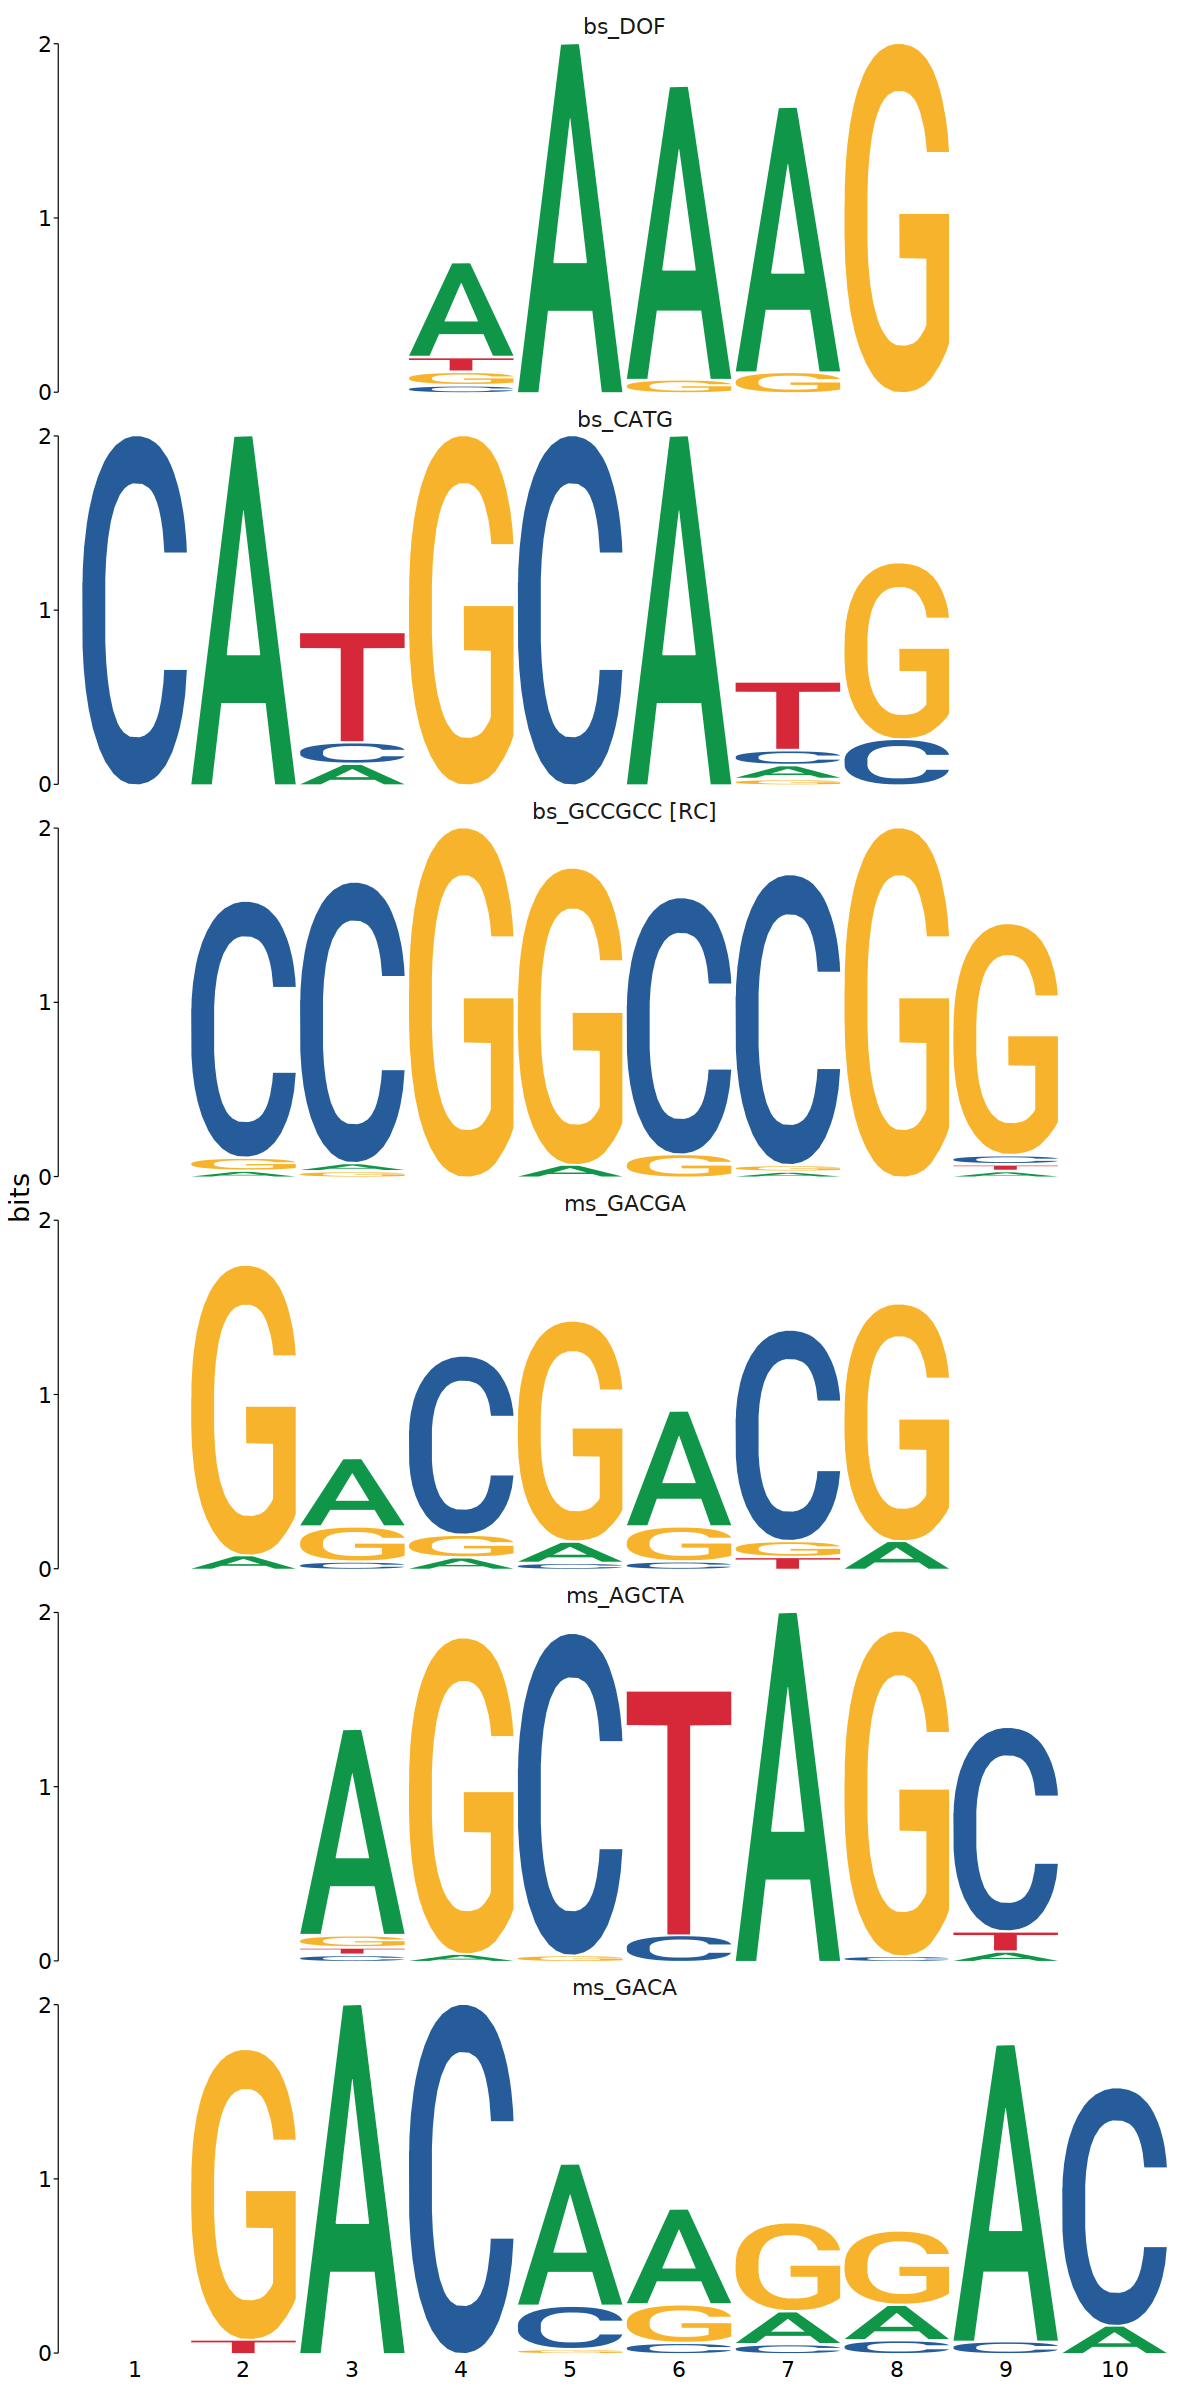

In [21]:
# Done Cleaning
bs_merged_dof_motif <- trim_motifs(merge_motifs(list(bs_reordered_motifs$Sb10, bs_reordered_motifs$Zm7, bs_reordered_motifs$Sb12, bs_reordered_motifs$Sb9),
                                                            min.mean.ic = 1.2,
                        normalise.scores = TRUE,
                        min.position.ic = 1,
                        tryRC = TRUE,
                        new.name = "bs_DOF"), min.ic = 1.2, trim.from = "right")

# Done Cleaning
bs_merged_CATG_motif <- trim_motifs(merge_motifs(list(bs_reordered_motifs$Sb11, bs_reordered_motifs$Zm6, bs_reordered_motifs$Pm9),
                                                             min.mean.ic = 1.2,
                        normalise.scores = TRUE,
                        min.position.ic = 1,
                        tryRC = TRUE,
                        new.name = "bs_CATG"), min.ic = .9, trim.from = "both")




## Done Cleaning
bs_GCCGCC <- trim_motifs(merge_motifs(list(bs_reordered_motifs$Zm17, bs_reordered_motifs$Pm10, bs_reordered_motifs$Uf11, bs_reordered_motifs$Sb13),
                       min.mean.ic = 1.2,
                        normalise.scores = TRUE,
                        min.position.ic = 1,
                        tryRC = TRUE,
                        new.name = "bs_GCCGCC"), min.ic = 1.2, trim.from = "both")



## Done Cleaning
ms_GACGA <- trim_motifs(merge_motifs(list(reordered_motifs$Sb1, reordered_motifs$Zm1, reordered_motifs$Uf2, reordered_motifs$Pm3, reordered_motifs$Pm3), 
                         min.mean.ic = 1.2,
                        normalise.scores = TRUE,
                        min.position.ic = 1,
                        tryRC = TRUE,
                        new.name = "ms_GACGA"), min.ic = 1.3, trim.from = "both")

# Done Cleaning
ms_AGCTA <- trim_motifs(merge_motifs(list(reordered_motifs$Uf11, reordered_motifs$Zm9, reordered_motifs$Sb17, reordered_motifs$Pm13), 
                         min.mean.ic = 1.2,
                        normalise.scores = TRUE,
                        min.position.ic = 1,
                        tryRC = TRUE,
                        new.name = "ms_AGCTA"), min.ic = 1.3, trim.from = "both")



# Done Cleaning
ms_GACA <- trim_motifs(merge_motifs(list(reordered_motifs$Uf7, reordered_motifs$Sb15, reordered_motifs$Zm7, reordered_motifs$Pm7), 
                         min.mean.ic = 1.2,
                        normalise.scores = TRUE,
                        min.position.ic = 1,
                        tryRC = TRUE,
                        new.name = "ms_GACA"), min.ic = 1.4, trim.from = "both")


finalized_list <- list(bs_merged_dof_motif, 
                        bs_merged_CATG_motif,
                        bs_GCCGCC,
                        ms_GACGA,
                        ms_AGCTA,
                        ms_GACA)



options(repr.plot.width=10, repr.plot.height=20)
motif_view <- view_motifs(finalized_list)
motif_view

ggsave(filename = "/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/figure_6/merged_motifs.pdf", 
       plot = motif_view, device = "pdf", width = 10, height = 20)


In [22]:
?write_meme

write_meme           package:universalmotif            R Documentation

_E_x_p_o_r_t _m_o_t_i_f_s _i_n _M_E_M_E _f_o_r_m_a_t.

_D_e_s_c_r_i_p_t_i_o_n:

     Convert motifs to minimal MEME format and write to file. See <URL:
     http://meme-suite.org/doc/meme-format.html>.

_U_s_a_g_e:

     write_meme(motifs, file, version = 5, bkg, strand, overwrite = FALSE,
       append = FALSE)
     
_A_r_g_u_m_e_n_t_s:

  motifs: See ‘convert_motifs()’ for acceptable formats.

    file: ‘character(1)’ File name.

 version: ‘numeric(1)’ MEME version.

     bkg: ‘numeric’ Background letter frequencies. If missing, will use
          background frequencies from motif objects (if they are
          identical); else background frequencies will be set to freq =
          1/length(alphabet)

  strand: ‘character’ If missing, will use strand from motif objects
          (if identical); otherwise will default to "+ -"

overwrite: ‘logical(1)’ Overwrite existing file.

  append: ‘logical(1)’ Add to an existing file. Motifs will be written
          in minimal format, so it is recommended to only use this if
          the existing file is also a minimal MEME format file.

_V_a_l_u_e:

     ‘NULL’, invisibly.

_A_u_t_h_o_r(_s):

     Benjamin Jean-Marie Tremblay, <email:
     benjamin.tremblay@uwaterloo.ca>

_R_e_f_e_r_e_n_c_e_s:

     Bailey TL, Boden M, Buske FA, Frith M, Grant CE, Clementi L, Ren
     J, Li WW, Noble WS (2009). “MEME SUITE: tools for motif discovery
     and searching.” _Nucleic Acids Research_, *37*, W202-W208.

_S_e_e _A_l_s_o:

     ‘read_meme()’

     Other write_motifs: ‘write_homer()’, ‘write_jaspar()’,
     ‘write_matrix()’, ‘write_motifs()’, ‘write_transfac()’

_E_x_a_m_p_l_e_s:

     transfac <- read_transfac(system.file("extdata", "transfac.txt",
                                         package = "universalmotif"))
     write_meme(transfac, tempfile())

In [23]:
write_meme(finalized_list, file = "/home/jpm73279/genome_downloads/C4_markers/found_motifs/combined_unique_motifs.meme",
          overwrite = TRUE)

# DEPRECTAED Fine Tuning Tree Building

[1] "Pair: TTYTTTTTYTT-MEME-2_Os_bundle_sheath_Os2 - 1-CGCGCGCGCGSSSSS-STREME-1_Os_bundle_sheath_Os9 with correlation 0.726209339667717"
[1] "Pair: CGCCGYCGYCGYCGC-MEME-1_Os_bundle_sheath_Os1 - 3-AGATTCC-STREME-3_Os_bundle_sheath_Os11 with correlation 0.658034229258787"
[1] "Pair: CYCTCYCTCYCYCYC-MEME-3_Os_bundle_sheath_Os3 - 3-AGATTCC-STREME-3_Os_bundle_sheath_Os11 with correlation 0.667728577656152"
[1] "Pair: GCGSGCGCGCGCSGC-MEME-4_Os_bundle_sheath_Os5 - 3-AGATTCC-STREME-3_Os_bundle_sheath_Os11 with correlation 0.664486691074601"
[1] "Pair: 1-CGCGCGCGCGSSSSS-STREME-1_Os_bundle_sheath_Os9 - 3-AGATTCC-STREME-3_Os_bundle_sheath_Os11 with correlation 0.719023556860375"
[1] "Pair: TTYTTTTTYTT-MEME-2_Os_bundle_sheath_Os2 - 4-CGCGNCGCG-STREME-4_Os_bundle_sheath_Os12 with correlation 0.714478390209562"
[1] "Pair: 3-AGATTCC-STREME-3_Os_bundle_sheath_Os11 - 4-CGCGNCGCG-STREME-4_Os_bundle_sheath_Os12 with correlation 0.684097567712994"
[1] "Pair: TTYTTTTTYTT-MEME-2_Os_bundle_sheath_Os2 - 7-CCC

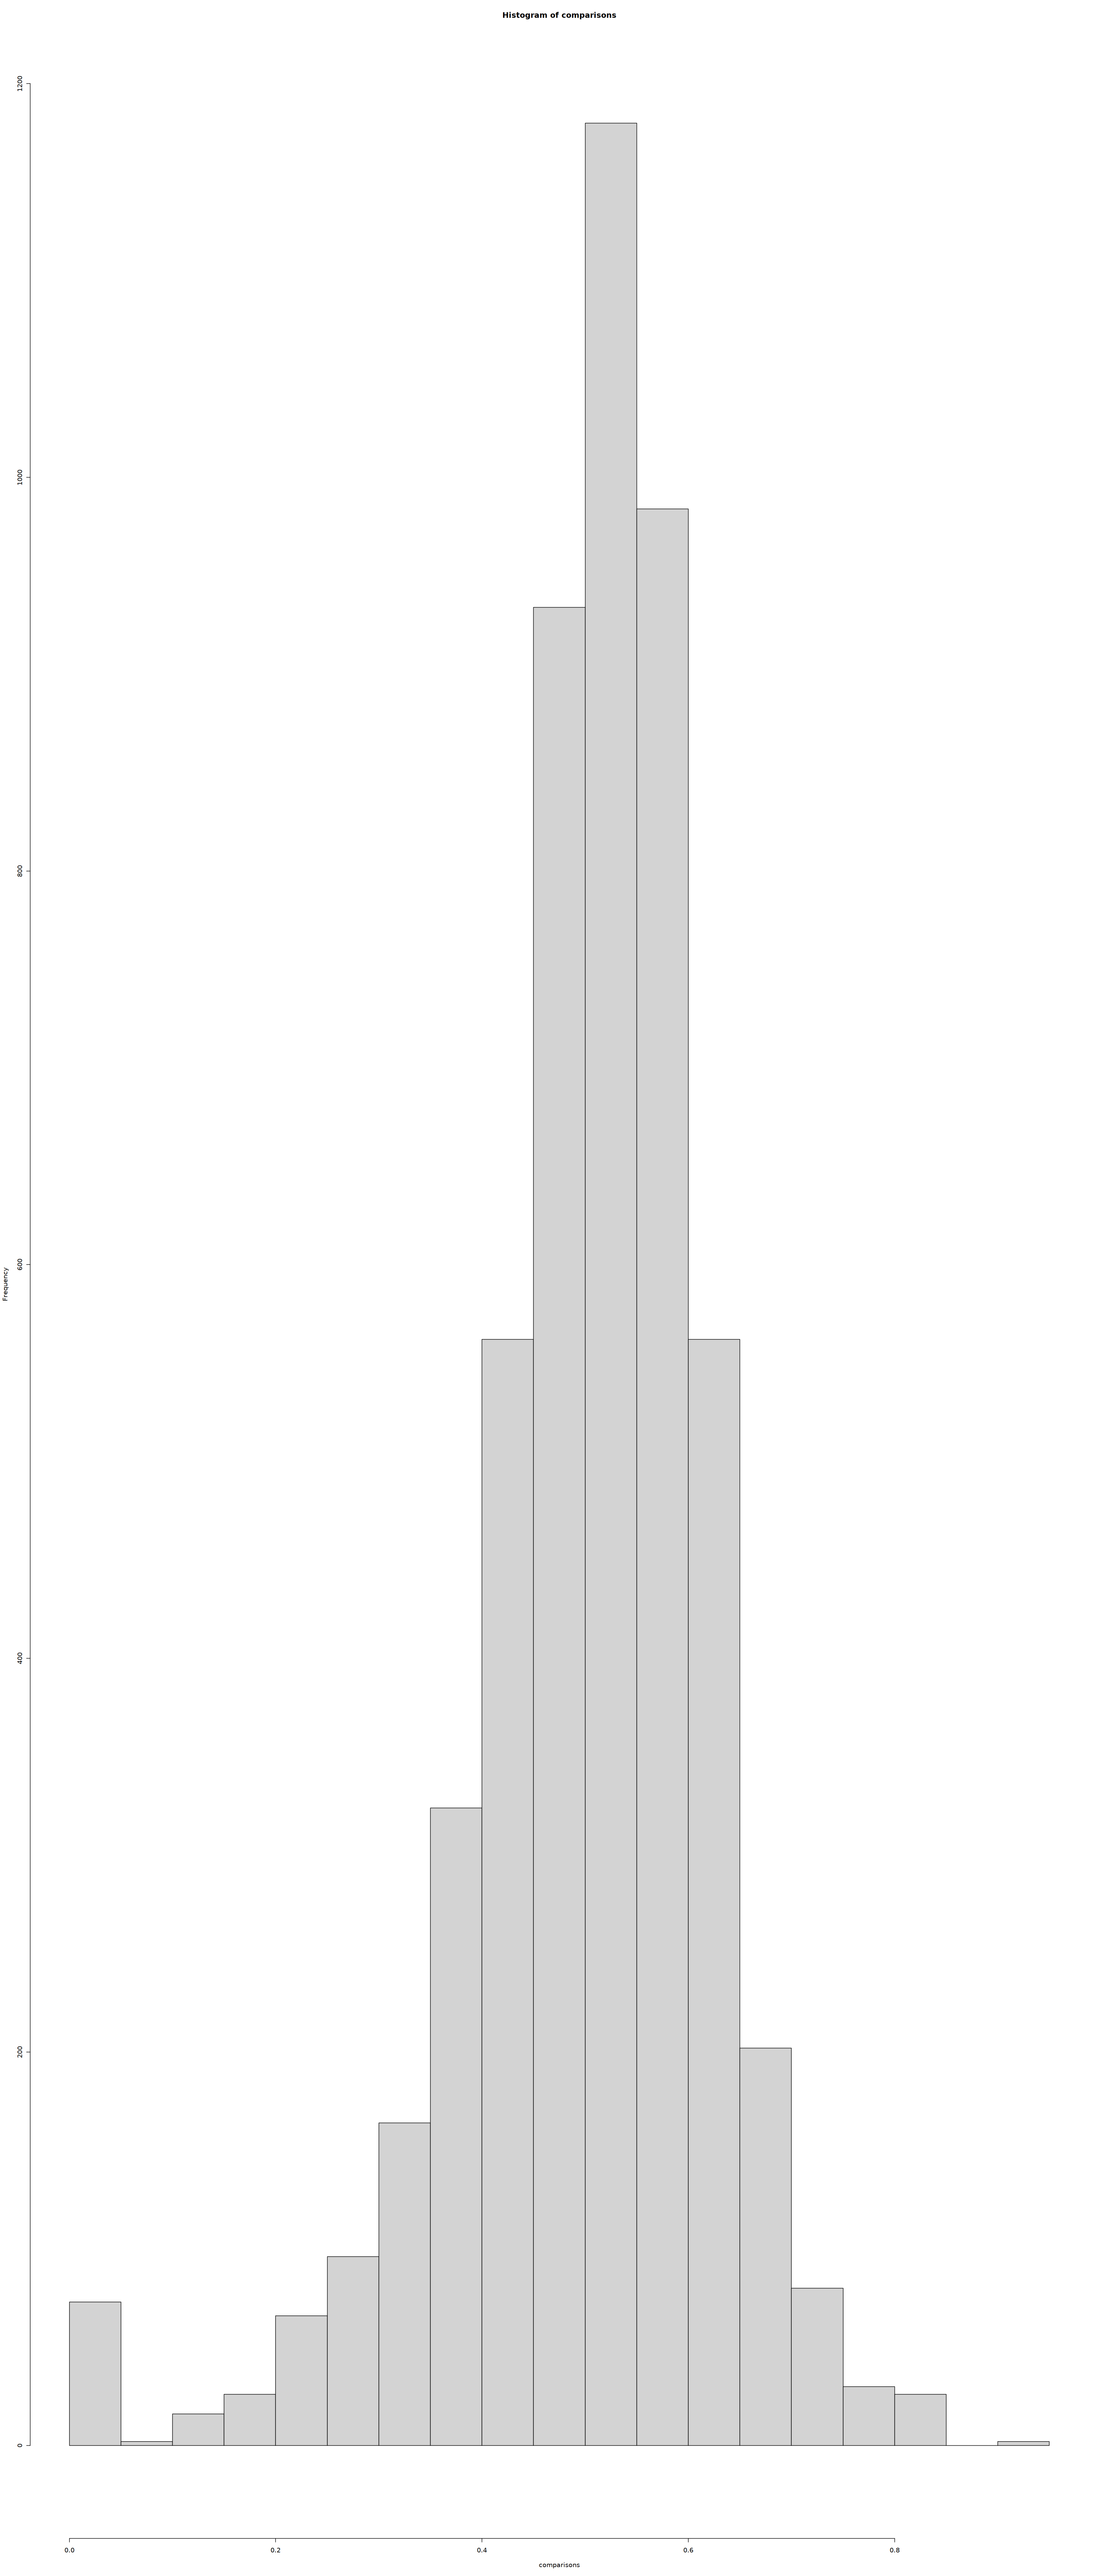

In [103]:

## Step 1: compare motifs
comparisons <- compare_motifs(bs_filtered_motifs, method = "HELL", min.mean.ic = 0, score.strat = "a.mean")

hist(comparisons)
# The current metric, PCC, is a similarity metric
#comparisons <- 1 - comparisons
#comparisons <- as.dist(comparisons)

# Assuming cor_matrix is your correlation matrix
threshold = 0.65


cor_matrix <- comparisons 
# Find indices of elements greater than the threshold
high_corr_indices = which(cor_matrix > threshold, arr.ind = TRUE)

# Filter out diagonal elements and redundant pairs
high_corr_pairs = high_corr_indices[high_corr_indices[, 1] < high_corr_indices[, 2], ]

# Extract pairs
for (i in 1:nrow(high_corr_pairs)) {
  row = high_corr_pairs[i, 1]
  col = high_corr_pairs[i, 2]
  print(paste("Pair:", rownames(cor_matrix)[row], "-", colnames(cor_matrix)[col], 
              "with correlation", cor_matrix[row, col]))
}





In [21]:
comparisons

In [27]:
most_similar_motifs <- list()

# Iterate over the filtered similar pairs
for (i in 1:nrow(similar_pairs_filtered)) {
    row = similar_pairs_filtered[i, 1]
    col = similar_pairs_filtered[i, 2]
    
    # Add the pair to the list along with its Hellinger distance
    most_similar_motifs[[i]] <- list(
        pair = c(row, col),
        distance = distance_matrix[row, col]
    )
}


In [ ]:


# Generate the motif tree
tree_bs <- motif_tree(bs_filtered_motifs, method = "HELL",  tryRC = TRUE,
                      layout = "rectangular", linecol = "family")

# Extract the order based on the tree
bs_new.order <- tree_bs$data$label[tree_bs$data$isTip]
bs_new.order <- rev(bs_new.order[order(tree_bs$data$y[tree_bs$data$isTip])])


# Extract names or altname from filtered_motifs
bs_motif_names <- sapply(bs_filtered_motifs, function(x) x@name)

# Match the names with the new_order
bs_order_index <- match(bs_new.order, bs_motif_names)

# Reorder filtered_motifs based on the matched index
bs_reordered_motifs <- bs_filtered_motifs[bs_order_index]


#filtered_motifs <- filtered_motifs[new.order]

options(repr.plot.width=20, repr.plot.height=60)

# Plot the motifs and the tree side by side
plot_grid(nrow = 1, rel_widths = c(1, -0.15, 1),
          tree_bs + xlab(""), NULL,
          view_motifs(bs_reordered_motifs <- bs_filtered_motifs[bs_order_index]
, names.pos = "right") +
            ylab(element_blank()) +
            theme(
              axis.line.y = element_blank(),
              axis.ticks.y = element_blank(),
              axis.text.y = element_blank(),
              axis.text = element_text(colour = "white")
            )
)

In [20]:
glimpse(comparisons)

In [ ]:
# We also want to extract names from the dist object to match annotations
labels <- attr(comparisons, "Labels")

In [ ]:
## Step 3: get the comparisons ready for tree-building
# The R package "ape" provides the necessary "as.phylo" function
comparison_fixed <- ape::as.phylo(hclust(comparisons))

In [ ]:
# Your cutree output
test <- cutree(hclust(comparisons), k = 8)

# Initialize a list to store the motifs for each cluster
clustered_motifs <- vector("list", length = max(test))
names(clustered_motifs) <- paste0("Cluster", 1:max(test))

# Iterate over each cluster
for (cluster in 1:max(test)) {
  # Find the names of motifs that belong to this cluster
  motif_names_in_cluster <- names(test)[test == cluster]

  # Match these names with the names in your motif_list
  index_in_motif_list <- sapply(bs_filtered_motifs, function(motif) motif@name %in% motif_names_in_cluster)

  # Extract the motifs that belong to this cluster
  clustered_motifs[[cluster]] <- bs_filtered_motifs[index_in_motif_list]
}

In [ ]:
process_and_plot_cluster <- function(motifs) {
  # Check if the list of motifs is empty
  if (length(motifs) == 0) {
    cat("No motifs found in this cluster.\n")
    return(NULL)
  }

  # Generate the motif tree
  tree_bs <- motif_tree(motifs, method = "HELL", layout = "rectangular", linecol = "family")

  # Extract the order based on the tree
  bs_new.order <- tree_bs$data$label[tree_bs$data$isTip]
  bs_new.order <- rev(bs_new.order[order(tree_bs$data$y[tree_bs$data$isTip])])

  # Extract names or altname from filtered_motifs
  bs_motif_names <- sapply(motifs, function(x) x@name)

  # Match the names with the new_order
  bs_order_index <- match(bs_new.order, bs_motif_names)

  # Reorder filtered_motifs based on the matched index
  bs_reordered_motifs <- motifs[bs_order_index]

  # Plot the motifs and the tree side by side
  plot_grid(nrow = 1, rel_widths = c(1, -0.15, 1),
            tree_bs + xlab(""), NULL,
            view_motifs(bs_reordered_motifs, names.pos = "right") +
              ylab(element_blank()) +
              theme(
                axis.line.y = element_blank(),
                axis.ticks.y = element_blank(),
                axis.text.y = element_blank(),
                axis.text = element_text(colour = "white")
              )
  )
}

options(repr.plot.width=20, repr.plot.height=20)
# Apply the function to each cluster
lapply(clustered_motifs, process_and_plot_cluster)
